# Classification on tabular data

This notebook shows how to solve the classification task on tabular data using the AutoML framework FEDOT

---

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team) 

"Nothing is clear but very interesting." - our lab's motto (but hope this tutorial will help you figure it out)

---

**Reminder**: FEDOT can build composite models from machine learning models and preprocessing operations. Composite models are also called ensembles, or pipelines. In such ensembles, first-level model predictions become features for second-level models, and so on. The final model in the pipeline that generates the final predictions is called the root node

Examples of pipelines:

<img src="../jupyter_media/pipeline_examples.png" width="500"/> 


## Installation

In [ ]:
pip install fedot==0.6.0

In [4]:
from fedot.api.main import Fedot

import pandas as pd
import numpy as np 

# Some imports to avoid unnecessary messages
import warnings
warnings.filterwarnings("ignore")
import logging
logging.raiseExceptions = False

Load data as pandas DataFrame object and try to predict the target column

In [5]:
df = pd.read_csv('../data/scoring_train.csv')
df.head(2)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0


## AutoML launch

Below is an example of the AutoML framework running for 1 minute (`timeout` parameter). 

You can also define the following useful parameters (not an entire list):
- `max_depth`: max depth of the pipeline
- `num_of_generations`: number of generations for composer
- `available_operations`: list of model names to use
- `with_tuning`: allow hyperparameters tuning for the model
- `cv_folds`: number of folds for cross-validation
- `validation_blocks`: number of validation blocks for time series forecasting
- `max_pipeline_fit_time`: time constraint for operation fitting (minutes)
- `initial_assumption`: initial assumption for composer
- `composer_metric`: metric for quality calculation during composing

In [6]:
# task selection, initialisation of the framework
model = Fedot(problem='classification', timeout=2)

# fit model with AutoML
train_columns = df.columns[:-1]
obtained_pipeline = model.fit(features=df[train_columns], target=df['target'])

Generations:   1%|▊                                                                           | 1/100 [00:00<?, ?gen/s]

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Generations:   1%|▊                                                                           | 1/100 [01:16<?, ?gen/s]

Hyperparameters optimization start


  1%|▌                                            | 12/1000 [00:42<58:26,  3.55s/trial, best loss: -0.8528746249065386]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 0.853 equal or bigger than initial (- 5% deviation) 0.809


Let's take a look at what the pipeline has turned out to be

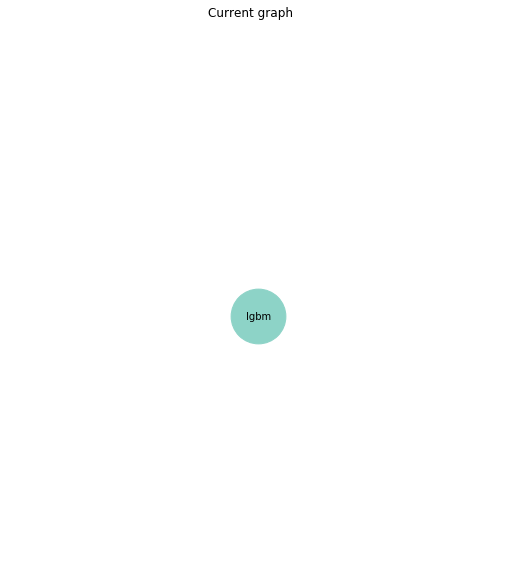

In [7]:
obtained_pipeline.show()

Demonstration of how the framework can predict

In [8]:
predictions = model.predict(features=df[train_columns])
print(f'Example of forecast: {predictions[:5]}')

Example of forecast: [[0]
 [0]
 [0]
 [0]
 [0]]


## Additional features (metrics and visualizations)

Note: These functions should be run once the training has been completed and when the predictions have been given for the whole training sample. These functions are auxiliary ones

Let's look at the metrics derived from the entire training sample

In [9]:
model.get_metrics(metric_names=['f1', 'acc', 'roc_auc'])

{'f1': 0.94295, 'acc': 0.94295, 'roc_auc': 0.907}

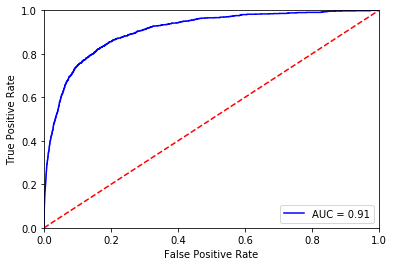

In [10]:
model.plot_prediction()

## A brief overview of how the optimisation is going
FEDOT uses an evolutionary algorithm. That is, a population is generated (consisting of several tens of pipelines) and then mutation, crossover and selection operators are applied.

## Optimization history visualization
Sometimes you want to know how the optimisation process went in the AutoML algorithm. First, let's look at the graph, where the x-axis shows generations and the y-axis shows boxplots with fitness values (the value of the metric on the test sample) for all individuals in a generation

Visualizing optimization history... It may take some time, depending on the history size.


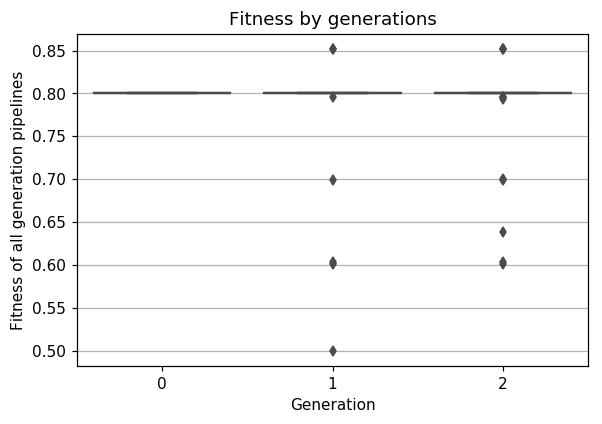

In [11]:
model.history.show('fitness_box')

Visualizing optimization history... It may take some time, depending on the history size.


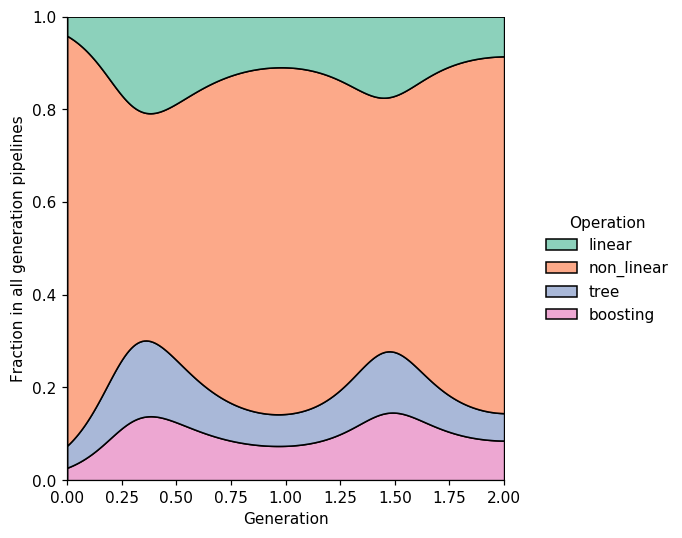

In [12]:
model.history.show('operations_kde')

In [13]:
model.history.show('operations_animated_bar', save_path='060_classification_2_animation.gif', show_fitness=True)

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


Visualizing optimization history... It may take some time, depending on the history size.
The animation was saved to "C:\Users\558\anaconda3\Jupyter Notebooks\notebooks\new_version\060_classification_2_animation.gif".


<img src="../jupyter_media/animations/060_classification_2_animation.gif" width="500"/> 

## Save and load model

Demonstration of how the resulting model can be saved and then used to generate predictions

In [15]:
obtained_pipeline.save('./models/pipeline.json')
print('Pipeline save finished!')

Pipeline save finished!


In [18]:
from fedot.core.pipelines.pipeline import Pipeline

# Load saved model
loaded_model = Fedot(problem='classification')
loaded_model.load('./models/June-29-2022,20-49-10,PM pipeline/pipeline.json')

predictions = loaded_model.predict(features=df[train_columns])
print(f'Example of forecast from loaded model: {predictions[:5]}')

Cannot export to template: 'NoneType' object is not subscriptable
Example of forecast from loaded model: [[0]
 [0]
 [0]
 [0]
 [0]]


If you want to get predictions of probabilities rather than labels

In [21]:
predicted_probs = loaded_model.predict_proba(features=df[train_columns])
print(f'Example of forecast from loaded model: {predicted_probs[:5]}')

Example of forecast from loaded model: [[0.37907527]
 [0.09920607]
 [0.12898226]
 [0.02743621]
 [0.1182992 ]]


In this notebook we looked at an example of how an AutoML algorithm can be run to solve a classification task on tabular data. We learned how to get metrics on a training sample, make cool graphs, serialize and load stored models